In [1]:
repo_path = 'D:\ProjGit\plinko\plinko_nn'

In [2]:
import sys
sys.path.append(repo_path + '/src')
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.distributions.normal import Normal

from plinko.misc import data_utils
from plinko.misc.simulation_dataset import SimulationDataset
from plinko.model.predictor_gru import GRUPredictor
from plinko.misc import plot as plinko_plot
from plinko.model.mlp import MLP
from plinko.misc import utils

from plotnine import * #ggplot, geom_point, aes, labs
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(0)
torch.manual_seed(0)
torch.set_default_tensor_type('torch.FloatTensor')
epsilon = sys.float_info.epsilon

df_ball = pd.read_feather(repo_path + '/data/simulations/sim_ball.feather')
df_env = pd.read_feather(repo_path + '/data/simulations/sim_environment.feather')
df_col = pd.read_feather(repo_path + '/data/simulations/sim_collisions.feather')

In [4]:
collisions = df_col.copy()
collisions = collisions.rename({'object': 'collision'}, axis=1)
collisions.t -= 1

collisions = df_ball.merge(collisions, how='left')
#collisions = collisions[~collisions.collision.isna()]
collisions.collision[collisions.collision.isna()] = 'none'
collisions.collision[(collisions.collision == 'walls') & (collisions.px < 200)] = 'left_wall'
collisions.collision[(collisions.collision == 'walls') & (collisions.px > 500)] = 'right_wall'
collisions = collisions.groupby('collision', as_index=False).apply(lambda x: x.sample(2000))
collisions = collisions.sort_values(['simulation', 'run', 't'])


env_columns = ['triangle_x', 'triangle_y', 'triangle_r',
               'rectangle_x', 'rectangle_y', 'rectangle_r',
               'pentagon_x', 'pentagon_y','pentagon_r']
envs = collisions.merge(df_env).sort_values(['simulation', 'run', 't'])[env_columns]

idx2col = sorted(collisions.collision.unique())
col2idx = {c: i for c, i in zip(idx2col, range(len(idx2col)))}

states = torch.tensor(collisions[['px', 'py', 'vx', 'vy']].values, dtype=torch.float, device=device)
targets = torch.tensor([col2idx[c] for c in collisions.collision], dtype=torch.long, device=device)
envs = torch.tensor(envs.values, dtype=torch.float, device=device)

# old versions
df_envs2 = df_env.copy()
df_envs2['triangle_rsin'] = np.sin(df_env['triangle_r'])
df_envs2['triangle_rcos'] = np.cos(df_env['triangle_r'])
df_envs2['rectangle_rsin'] = np.sin(df_env['rectangle_r'])
df_envs2['rectangle_rcos'] = np.cos(df_env['rectangle_r'])
df_envs2['pentagon_rsin'] = np.sin(df_env['pentagon_r'])
df_envs2['pentagon_rcos'] = np.cos(df_env['pentagon_r'])

env_trig_columns = ['triangle_x', 'triangle_y', 'triangle_rsin','triangle_rcos',
               'rectangle_x', 'rectangle_y', 'rectangle_rsin','rectangle_rcos',
               'pentagon_x', 'pentagon_y','pentagon_rsin', 'pentagon_rcos']
envs_trig = collisions.merge(df_envs2).sort_values(['simulation', 'run', 't'])[env_trig_columns]

In [9]:
model = MLP(input_size=[9, 4],
            hidden_layer_size=[16,16,16,16,16],
            activation=F.elu,
            output_size=len(idx2col)).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
epochs = 3000

rows = []
for epoch in tqdm(range(epochs+1)):
    optimizer.zero_grad()
    outputs = model(envs, states)
    loss = F.cross_entropy(outputs, targets)
    loss.backward()
    optimizer.step()
    
    loss = float(loss)
    corrects = (outputs.argmax(-1) == targets).float()
    accuracy = float(corrects.mean())
    row = {'epoch': epoch, 'loss': loss, 'acc_total': accuracy}
    for idx in range(len(idx2col)):
        row['acc_' + idx2col[idx]] = float(corrects[targets == idx].mean())
    rows.append(row)
    if epoch%100 == 0:
        print(epoch, round(loss, 4), round(accuracy, 4))
        
summary = pd.DataFrame(rows)

0 4.0187 0.1425
100 1.2352 0.5211
200 0.6694 0.7356
300 0.4057 0.8569
400 0.2961 0.9016
500 0.2259 0.9299
600 0.1875 0.9434
700 0.1633 0.9498
800 0.1412 0.9567
900 0.1205 0.9632
1000 0.1051 0.9679
1100 0.0948 0.9709
1200 0.0877 0.9728
1300 0.0822 0.9748
1400 0.075 0.9784
1500 0.0705 0.9802
1600 0.0673 0.9811
1700 0.0641 0.9805
1800 0.0618 0.9815
1900 0.0587 0.9835
2000 0.0589 0.9823
2100 0.0556 0.9843
2200 0.0538 0.9855
2300 0.052 0.9859
2400 0.0505 0.9864
2500 0.0495 0.9871
2600 0.0479 0.9869
2700 0.0475 0.9869
2800 0.0468 0.986
2900 0.0447 0.9881
3000 0.0443 0.9872



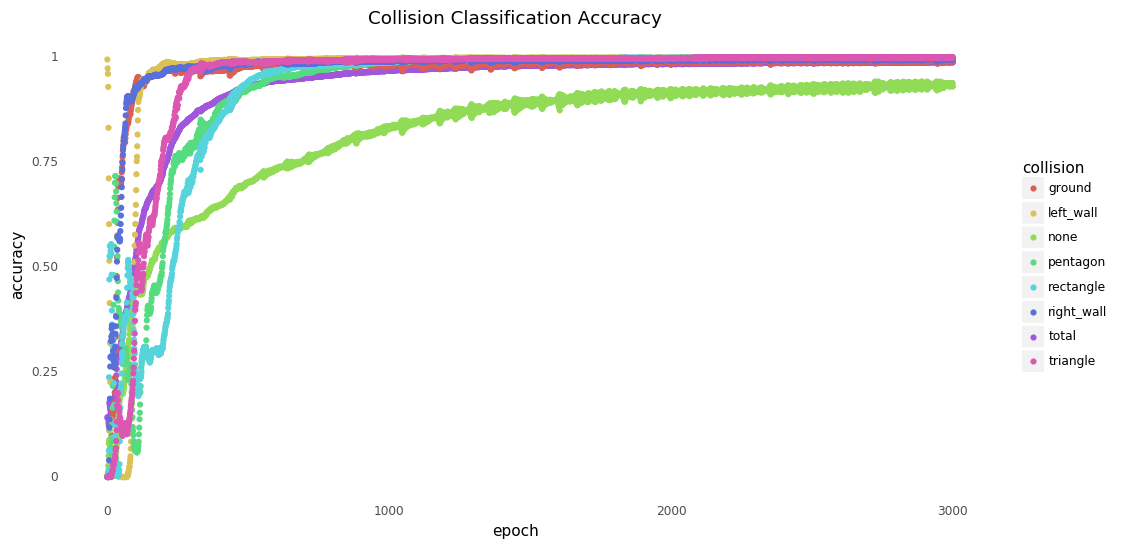

<ggplot: (-9223371879751248352)>

In [10]:
accuracies = summary.drop('loss', axis=1)
accuracies = pd.melt(accuracies, id_vars='epoch', var_name='collision')
accuracies.collision = [a[4:] for a in accuracies.collision]
accuracies = accuracies.rename({'value': 'accuracy'}, axis=1)

(ggplot(accuracies)
     + geom_point(aes(x='epoch', y='accuracy', color='collision'))
     + labs(title='Collision Classification Accuracy')
     + ylim(0, 1)
     + theme(
             figure_size=(12, 6),
             panel_background=element_blank(),
             line=element_blank(),
             panel_border=element_blank(),
            )
)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

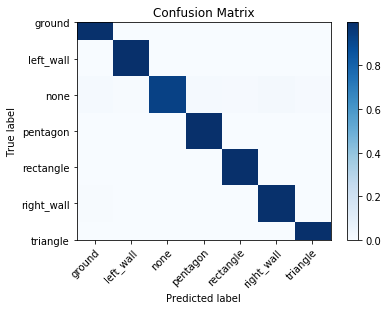

In [11]:
cm = confusion_matrix(targets.cpu(), outputs.argmax(-1).cpu())
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize
classes = idx2col

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")